<a href="https://colab.research.google.com/github/raj26000/Python-and-Machine-Learning/blob/main/DrivenDataRichter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Importing Data and required Libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
import lightgbm as lgb

from google.colab import drive
from google.colab import files

     |████████████████████████████████| 67.3MB 59kB/s 


In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/train_values.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test_values.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/train_labels.csv')
train_data

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


# II. Exploratory Data Analysis - Steps.



*  **Checking for Missing values in train and test data**



In [4]:
train_data.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [5]:
test_data.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       



*   **EDA on variable Properties and distributions.**



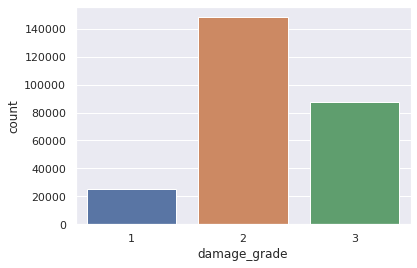

In [22]:
#Distribution of classes - MultiLabel Classification.
sns.set()
sns.countplot(x = train_labels['damage_grade'])
y_train = train_labels['damage_grade']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0081d43050>,
      dtype=object)

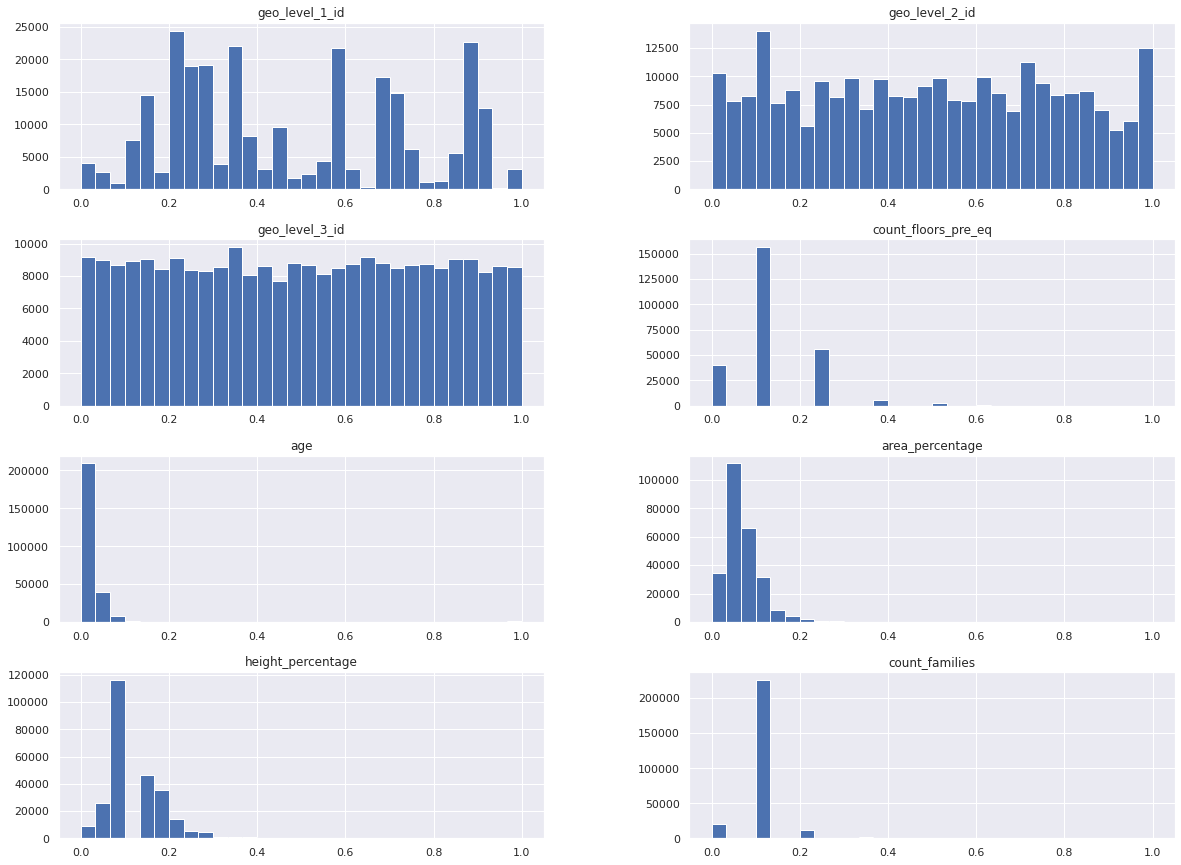

In [23]:
#Histogram to check distribution of numerical variables. If Gaussian, can perform StandardScaler, else MinMaxScaler.
numerical = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 
             'height_percentage', 'count_families']
train_data[numerical].hist(layout=(4,2), figsize=(20,15), bins=30)

<class 'list'>


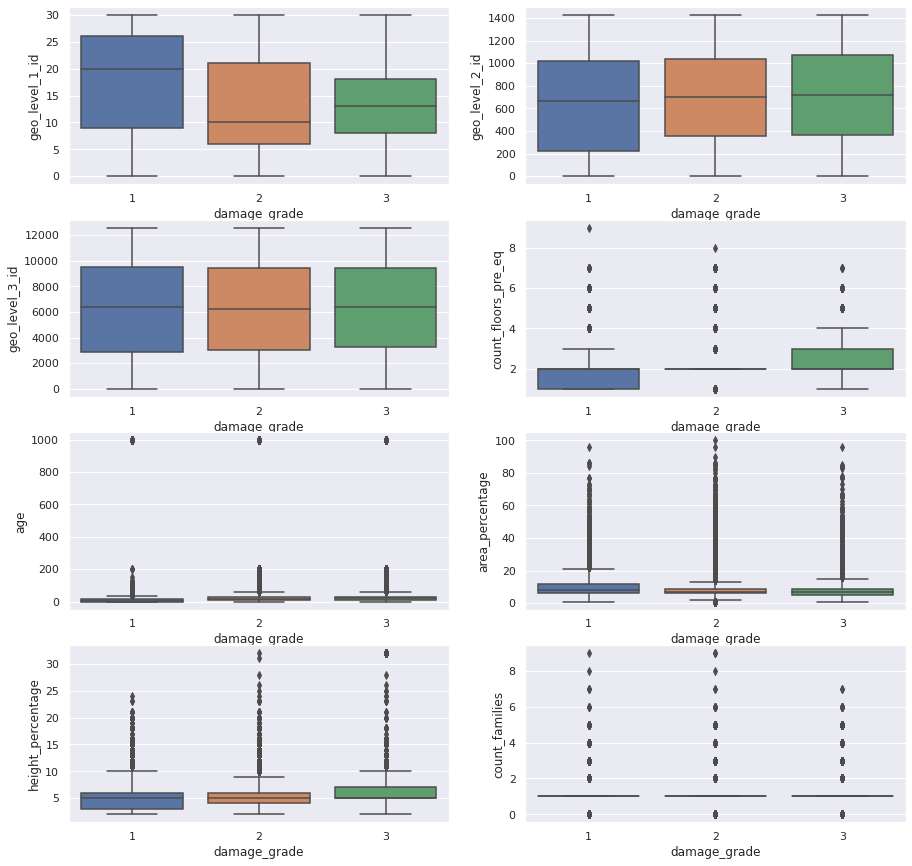

In [8]:
#Boxplots between numerical features and target variables to identify outliers.
fig, ax = plt.subplots(4, 2, figsize=(15,15))
for var, subplot in zip(numerical, ax.flatten()):
  sns.boxplot(x=y_train, y=train_data[var], ax=subplot)
print(type(numerical))



*   **Feature Encoding and Normalization.**



In [9]:
categorical = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 
               'plan_configuration', 'legal_ownership_status']
encoder = LabelEncoder()
for feat in categorical:
  train_data[feat] = encoder.fit_transform(train_data[feat])
  test_data[feat] = encoder.transform(test_data[feat])

In [10]:
scaler = MinMaxScaler()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
for col in numerical:
  X_train[col] = train_data[col]
  X_test[col] = test_data[col]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train = pd.DataFrame(data=X_train, columns=numerical)
X_test = pd.DataFrame(data=X_test, columns=numerical)
test_ids = test_data['building_id']
for col in X_train.columns:
    train_data[col] = X_train[col]
    test_data[col] = X_test[col]
train_data = train_data.drop(['building_id'], axis=1)
test_data = test_data.drop(['building_id'], axis=1)
test_data

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,0.566667,0.417659,0.899737,0.250,0.020101,0.060606,0.133333,2,2,0,0,1,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0.111111,0,0,0,0,0,0,0,0,0,0,0
1,0.200000,0.098809,0.953847,0.125,0.025126,0.121212,0.100000,2,2,0,0,1,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0.111111,1,1,0,0,0,0,0,0,0,0,0
2,0.733333,0.013315,0.799236,0.125,0.005025,0.030303,0.100000,2,2,0,0,1,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0.111111,0,0,0,0,0,0,0,0,0,0,0
3,0.866667,0.027330,0.050370,0.000,0.000000,0.181818,0.033333,2,2,2,2,0,3,2,0,0,0,0,0,1,0,0,0,0,0,2,0.222222,1,0,0,1,0,0,0,0,0,0,0
4,0.566667,0.202523,0.634201,0.250,0.015075,0.070707,0.166667,2,2,1,0,1,3,2,0,1,0,0,0,0,0,0,0,0,0,2,0.111111,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,0.133333,0.423966,0.288295,0.250,0.070352,0.191919,0.133333,2,2,1,0,1,3,2,0,1,0,0,0,0,1,0,0,0,0,3,0.111111,1,1,0,0,0,0,0,0,0,0,0
86864,0.333333,0.985985,0.947481,0.250,0.025126,0.050505,0.166667,0,2,0,0,1,2,2,1,1,1,0,0,0,0,0,0,0,0,2,0.111111,0,0,0,0,0,0,0,0,0,0,0
86865,0.733333,0.796076,0.613671,0.000,0.050251,0.020202,0.033333,2,2,0,0,0,2,2,0,1,0,0,0,0,1,0,0,0,0,2,0.111111,0,0,0,0,0,0,0,0,0,0,0
86866,0.200000,0.729502,0.072571,0.125,0.005025,0.080808,0.100000,2,2,0,0,1,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0




*   **Feature Selection**



In [12]:
#chi2 test for categorical variables. Drop columns whose p-value exceeds 0.05.
df_cat = pd.DataFrame()
drop_col = []
for col in train_data.columns:
  if col not in numerical:
    df_cat[col] = train_data[col]
f_score, p_value = chi2(df_cat, y_train)
for i in range(len(p_value)):
  if p_value[i] > 0.05:
    drop_col.append(df_cat.columns[i])

train_data = train_data.drop(drop_col, axis=1)
test_data = test_data.drop(drop_col, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


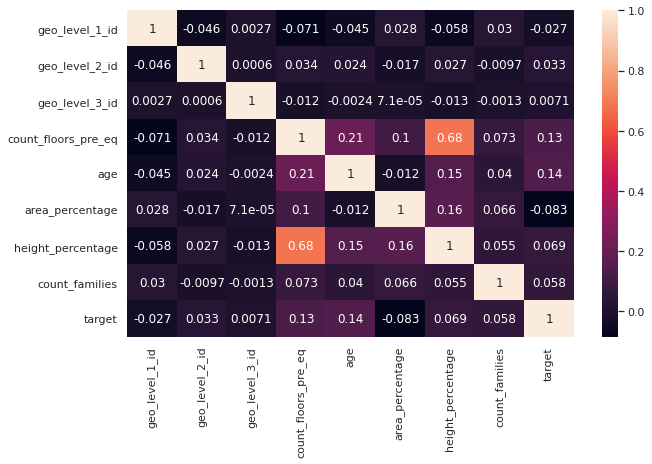

In [13]:
#Kendall Tau Correlation function for checking multi-collinearity among numerical variables - No extreme correlation found.
df_num = train_data[numerical]
df_num['target'] = y_train
cor_df = df_num.corr(method='kendall')
plt.figure(figsize=(10,6))
sns.heatmap(cor_df, annot=True)

# III. Model Training and Prediction





*   Using LightGBM Classifier for final predictions as it gave best performance among other alogrithms.





In [20]:
clf = lgb.LGBMClassifier(n_estimators=20000, max_depth=10, num_leaves=15)
clf.fit(train_data, y_train)
print(clf.feature_importances_)
y_pred = clf.predict(test_data)
#Data size too large to perform GridSearch hyperparameter tuning.

[ 70241 125913 153884  17068  97720 107205  56981  15610  14578  18311
  15938  18508  19734   8168   5317   9925   2801   2645   4935   6212
  12198   5969   4419   1832   2221   5506  17101   6586   4582   3535
   1419    311    257    505    318    305   1242]


In [21]:
#Final Score on test-set : 0.7457 (micro-F1 score.)
df = pd.DataFrame()
df['building_id'] = test_ids
df['damage_grade'] = y_pred
df.to_csv('MultiLabels.csv', index=False)
files.download('MultiLabels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>